In [134]:
%matplotlib inline

from sequencing_tools.viz_tools import RNA_base_from_picard, \
                            RNA_cov_from_picard, color_encoder, \
                            okabeito_palette, simpsons_palette
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import re
from plotting_utils import label_sample
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
plt.rc('legend', fontsize = 15)

def label_sample(x):
    if 'HS' in x:
        return 'High salt'
    elif 'Frag' in x:
        return 'Fragmented'
    elif re.search('N[aA]', x):
        return 'Alkaline hydrolysis'
    elif re.search('L[12]',x):
        return 'PolyA-selected'
    elif re.search('Exo|ED|DE', x):
        return 'Exonuclease I'
    elif 'All' in x:
        return 'Untreated'
    else:
        return 'Unfragmented'

In [40]:
metrics_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/picard_qc'
metrics = glob.glob(metrics_path + '/*sense.RNA_Metrics')

Text(0.5,0,' ')

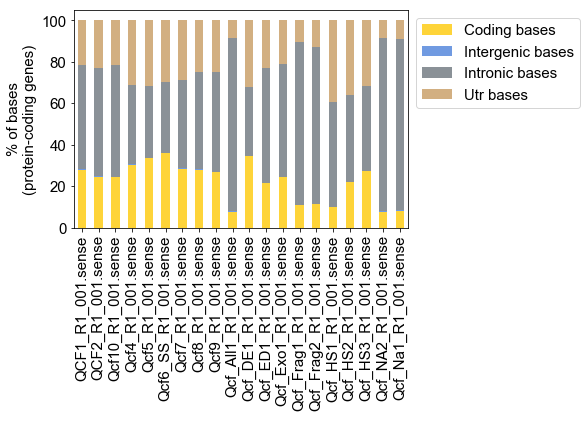

In [41]:
plot_df = RNA_base_from_picard(metrics) \
    .assign(samplename = lambda d: d.samplename.str.replace('.RNA_Metrics','')) \
    .assign(treatment = lambda d: d.samplename)\
    .sort_values('treatment') \
    .assign(var_count = lambda d: d.var_count * 100)\
    .assign(label = lambda d: d.treatment.map(label_sample))

fig = plt.figure()
ax = fig.add_subplot(111)
plot_df\
    .pipe(pd.pivot_table, columns = 'variable', 
          index = 'samplename', values = 'var_count')\
    .plot.bar(stacked=True, color = simpsons_palette(), 
              ax= ax)
ax.legend(bbox_to_anchor = (1,1), fontsize = 15)
ax.set_ylabel('% of bases\n(protein-coding genes)')
ax.set_xlabel(' ')

In [63]:
plot_df.query('variable == "Intronic bases"').groupby('label', as_index=False).agg({'var_count':['min','max']})

label var_count         
                             min      max
0  Alkaline hydrolysis   82.7845  83.5057
1        Exonuclease I   33.4580  55.5907
2           Fragmented   75.7886  78.3642
3            High salt   40.8873  50.5066
4         Unfragmented   34.5378  54.2946
5            Untreated   83.4468  83.4468

In [42]:
plot_df.query('variable == "Coding bases"').groupby('label', as_index=False).agg({'var_count':['min','max']})

label var_count         
                             min      max
0  Alkaline hydrolysis    7.6252   8.1067
1        Exonuclease I   21.3275  34.4992
2           Fragmented   10.8207  11.4212
3            High salt    9.9529  27.2184
4         Unfragmented   24.2124  35.7739
5            Untreated    7.7224   7.7224

In [48]:
metrics_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/picard_qc'
metrics = glob.glob(metrics_path + '/*.filtered.RNA_Metrics')

cov_df = RNA_cov_from_picard(metrics)\
    .assign(samplename = lambda d: d.samplename.str.replace('.sense.RNA_Metrics',''))\
    .assign(treatment = lambda d: d.samplename)\
    .groupby(['normalized_position','treatment'], as_index=False)\
    .agg({'All_Reads.normalized_coverage': 'mean'}) \
    .assign(treatment = lambda d: d.treatment.str.replace('.filtered.RNA_Metrics','')) 
cov_df.head()

,normalized_position,treatment,All_Reads.normalized_coverage
0,0,QCF1_R1_001,0.655173
1,0,QCF2_R1_001,0.408469
2,0,Qcf10_R1_001,0.275989
3,0,Qcf4_R1_001,0.729051
4,0,Qcf5_R1_001,0.421365


Text(0,0.5,'Normalized coverage')

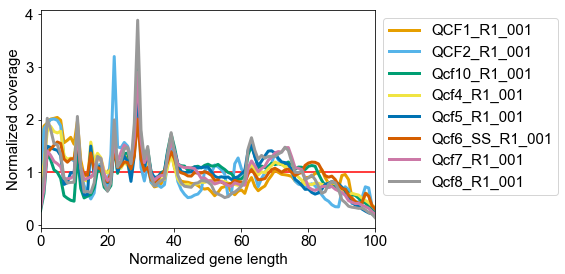

In [49]:
ax = plt.subplot(111)
for (t, t_df), color in zip(cov_df.groupby('treatment'), okabeito_palette()):
    if not 'untrea' in t and 'high' not in t:
        ax.plot(t_df['normalized_position'], t_df['All_Reads.normalized_coverage'],
           color = color, label = t,
           linewidth=3)
ax.legend(bbox_to_anchor = (1,1), fontsize = 15)
ax.hlines(y = 1, xmin= -10, xmax = 110, color = 'red')
ax.set_xlim(0,100)
ax.set_xlabel('Normalized gene length')
ax.set_ylabel('Normalized coverage')

Text(0,0.5,'% of bases')

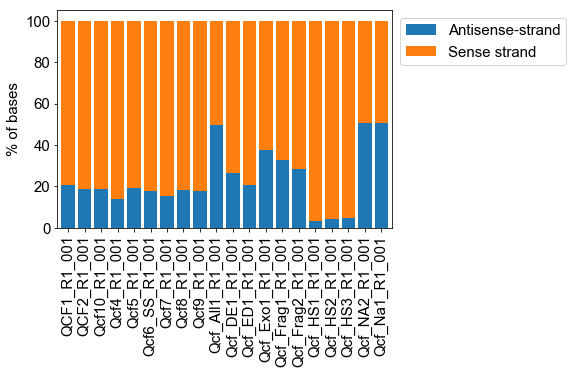

In [56]:
import os

ax = plt.subplot(111)
def read_metric(metric):
    return pd.read_table(metric, skiprows=6, nrows=1)\
        .pipe(pd.melt) \
        .pipe(lambda d: d[d.variable.str.contains('TRANSCRIPT_STRAND_')])\
        .pipe(lambda d: d[d.variable.str.contains('PCT')]) 

metrics_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/picard_qc/'
metrics = glob.glob(metrics_path + '/*.filtered.RNA_Metrics')

strand_df = {os.path.basename(metric).split('.')[0]: read_metric(metric) for metric in metrics}
strand_df = pd.concat([d.assign(samplename = k) for k, d in strand_df.items()])\
    .assign(variable = lambda d: np.where(d.variable.str.contains('R1'), 'Sense strand','Antisense-strand'))\
    .assign(value = lambda d: d['value'] * 100)\
    .pipe(pd.pivot_table, index='samplename', columns = 'variable', values = 'value')
strand_df.plot.bar(stacked=True, ax = ax, width = 0.8)
ax.legend(bbox_to_anchor = (1,1), fontsize = 15)
ax.set_xlabel(' ')
ax.set_ylabel('% of bases')

In [61]:
strand_df\
    .reset_index()\
    .assign(label = lambda d: d.samplename.map(label_sample))\
    .groupby('label')\
    .agg({'Sense strand':['min','max']})

Sense strand         
                             min      max
label                                    
Alkaline hydrolysis      49.2934  49.3613
Exonuclease I            62.2635  79.5004
Fragmented               67.4178  71.5324
High salt                95.0833  96.6879
Unfragmented             79.2312  86.1064
Untreated                50.3517  50.3517

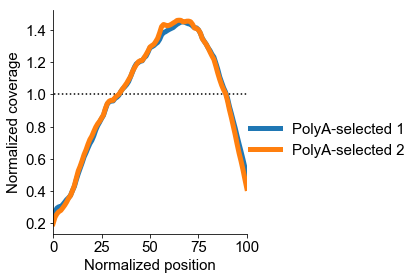

In [85]:
long_picard = glob.glob('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Qcf_L*')
long_picard_metric = map(lambda x: x + '/Combined/primary_no_sncRNA_tRNA_rRNA.RNA_Metrics', long_picard)


cov_df = pd.concat(map(lambda x: pd.read_table(x, skiprows=10)\
            .assign(samplename = re.findall('L[12]', x)[0]), 
        long_picard_metric)) \
    .assign(samplename = lambda d: np.where(d.samplename == "L1", 'PolyA-selected 1', 'PolyA-selected 2'))


p = sns.FacetGrid(data = cov_df, hue='samplename', size = 4)
p.map(plt.plot, 
      'normalized_position', 
      'All_Reads.normalized_coverage', 
      linewidth=5)
p.fig.axes[0].hlines(y=1, xmin = -10,xmax = 110, linestyle=":")
p.set(xlim = (0,100))
p.set_axis_labels('Normalized position',
                  'Normalized coverage')
p.add_legend(title = '', frameon=False, fontsize = 15)

In [53]:
insert_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/fragment_sizes'
data_files = glob.glob(insert_path + '/*.tsv')
df = {os.path.basename(data_file):pd.read_table(data_file) for data_file in data_files}
df = pd.concat([val.assign(label = key) for key, val in df.items()]) \
    .assign(label = lambda d: d.label.str.replace('.tsv','').str.capitalize())\
    .assign(label = lambda d: np.where(d.label == 'Polya','PolyA-selected', d.label))\
    .sort_values('isize') \
    .query('isize < 400') \
    .assign(size_fraction = lambda d: d.groupby('label')['size_count'].transform(lambda x: 100* x/ x.sum()))
df.head()

,isize,size_count,label,size_fraction
7687,14,1,PolyA-selected,0.000043
363,14,2206,Unfragmented,0.014304
147,14,163,Fragmented,0.001762
373,14,202,High_salt,0.012109
246,14,1350,Exo,0.017626


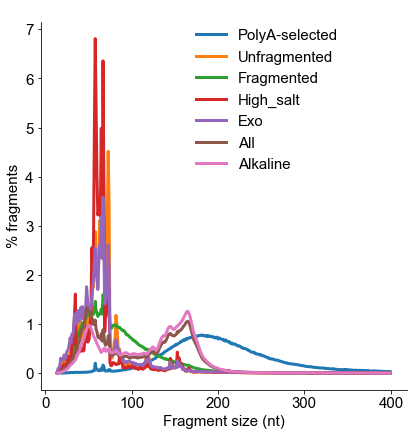

In [54]:
p = sns.FacetGrid(data = df,#.pipe(lambda d: d[d.label.str.contains('Pol|rag')]),
             hue = 'label',
             size = 6)
p.map(plt.plot, 'isize', 'size_fraction', linewidth=3)
p.add_legend(title= ' ', fontsize = 15, frameon=False, bbox_to_anchor = (0.6,0.8))
p.set_axis_labels('Fragment size (nt)', '% fragments')

In [117]:
def read_cov(file):
    samplename = re.sub('\.High|\.Low|\.Medium','',os.path.basename(file).replace('.geneBodyCoverage.txt',''))
    return pd.read_table(file,  index_col=0)\
        .transpose()\
        .reset_index() \
        .rename(columns = {samplename:'coverage'}) \
        .assign(expr = re.search('(High|Low|Medium)', os.path.basename(file)).group(0))\
        .assign(samplename = samplename)


path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bam/filtered_bam'
files = glob.glob(path + '/polyA.*.geneBodyCoverage.txt')
files = filter(lambda x: os.stat(x).st_size > 0 , files)
files = filter(lambda x: not re.search('plus|minus|anti',x), files)
files = filter(lambda x: not re.search('sense',x), files)
files = list(files)
cov_df = pd.concat(map(read_cov, files)) \
    .assign(norm_cov = lambda d: d.groupby(['expr','samplename'])['coverage']\
                            .transform(lambda x: (x - x.min()) / (x.max() - x.min()))) \
    .assign(index = lambda d: d['index'].astype(int))
cov_df.head()

Percentile,index,coverage,expr,samplename,norm_cov
0,1,3935.0,Low,polyA,0.000000
1,2,4379.0,Low,polyA,0.093356
2,3,5307.0,Low,polyA,0.288478
3,4,5242.0,Low,polyA,0.274811
4,5,5486.0,Low,polyA,0.326114


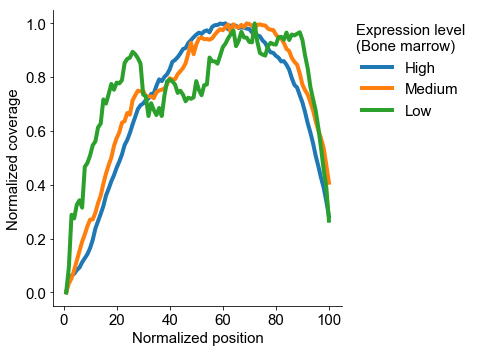

In [151]:
p = sns.FacetGrid(data = cov_df,#.pipe(lambda d: d[d.samplename.str.contains('frag|pol')]), 
                 hue = 'expr',
                  size = 5,
                 hue_order=['High','Medium','Low'])
p.map(plt.plot, 'index','norm_cov', linewidth=4)
ax = p.fig.axes[0]

ax.legend(title= 'Expression level\n(Bone marrow)',
             frameon=False, fontsize = 15, 
          bbox_to_anchor = (1,1))
plt.setp(ax.get_legend().get_title(), fontsize='15')
p.set_titles('{col_name}')
p.set_axis_labels('Normalized position','Normalized coverage')